# Ex 1

1. Generaţi 500 de date dintr-o mixtură de trei distribuţii Gaussiene. În fişierul alăturat aveţi un astfel de
exemplu.

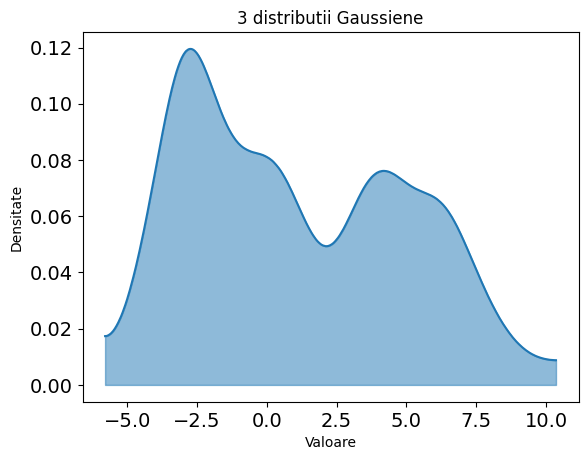

Primele 10 valori generate: [3.99804312 3.83223072 9.16760614 1.19952753 7.18451802 4.87029084
 6.76969147 4.06020554 5.14162479 5.04589977]


In [ ]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

clusters = 3
n_cluster = [200, 150, 150]
n_total = sum(n_cluster)
means = [5, 0, -3]
std_devs = [2, 1.5, 1]

mix = np.random.normal(
    np.repeat(means, n_cluster),
    np.repeat(std_devs, n_cluster)
)

az.plot_kde(mix, fill_kwargs={"alpha": 0.5})
plt.title("3 distributii Gaussiene")
plt.xlabel("Valoare")
plt.ylabel("Densitate")
plt.show()

print("Primele 10 valori generate:", mix[:10])


2. Calibraţi pe acest set de date un model de mixtură de distribuţii Gaussiene cu 2, 3, respectiv 4 compo-
nente.

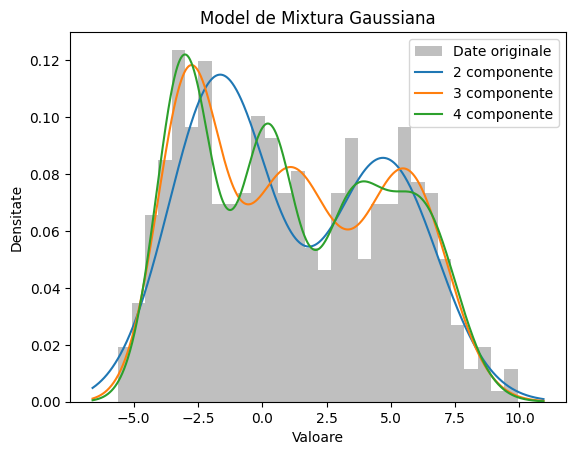


Model cu 2 componente:
Ponderi: [0.43894794 0.56105206]
Medii: [ 4.74168395 -1.66677786]
Deviatii standard: [2.0573286  1.95945574]

Model cu 3 componente:
Ponderi: [0.32029082 0.34943099 0.33027819]
Medii: [ 5.58611979 -2.84746643  1.06580866]
Deviatii standard: [1.59738133 1.23096568 1.64165315]

Model cu 4 componente:
Ponderi: [0.23050824 0.25179744 0.19008073 0.32761359]
Medii: [ 6.17262355  0.22201083  3.4660069  -3.02600464]
Deviatii standard: [1.37299379 1.05766902 1.17786861 1.07911196]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

clusters = 3
n_cluster = [200, 150, 150]
means = [5, 0, -3]
std_devs = [2, 1.5, 1]
mix = np.random.normal(
    np.repeat(means, n_cluster),
    np.repeat(std_devs, n_cluster)
)

components = [2, 3, 4]
models = {}
for n in components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(mix.reshape(-1, 1))
    models[n] = gmm

x = np.linspace(mix.min() - 1, mix.max() + 1, 1000).reshape(-1, 1)
plt.hist(mix, bins=30, density=True, alpha=0.5, color='gray', label='Date originale')

for n, model in models.items():
    pdf = np.exp(model.score_samples(x))
    plt.plot(x, pdf, label=f'{n} componente')

plt.title("Model de Mixtura Gaussiana")
plt.xlabel("Valoare")
plt.ylabel("Densitate")
plt.legend()
plt.show()

for n, model in models.items():
    print(f"\nModel cu {n} componente:")
    print("Ponderi:", model.weights_)
    print("Medii:", model.means_.flatten())
    print("Deviatii standard:", np.sqrt(model.covariances_).flatten())


3. Comparaţi cele 3 modele folosind metodele WAIC şi LOO. Care este concluzia?

In [ ]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

clusters = 3
n_cluster = [200, 150, 150]
means = [5, 0, -3]
std_devs = [2, 1.5, 1]
mix = np.random.normal(
    np.repeat(means, n_cluster),
    np.repeat(std_devs, n_cluster)
)

def run_gmm_model(data, n_components):
    with pm.Model() as model:
        weights = pm.Dirichlet("weights", a=np.ones(n_components))

        means = pm.Normal("means", mu=0, sigma=10, shape=n_components)
        stds = pm.HalfNormal("stds", sigma=5, shape=n_components)

        component = pm.Categorical("component", p=weights, shape=len(data))

        obs = pm.Normal("obs", mu=means[component], sigma=stds[component], observed=data)

        trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    return model, trace

models_traces = {}
for n in [2, 3, 4]:
    model, trace = run_gmm_model(mix, n)
    models_traces[n] = (model, trace)

waic_results = {n: az.waic(trace) for n, (_, trace) in models_traces.items()}
loo_results = {n: az.loo(trace) for n, (_, trace) in models_traces.items()}

print("Rezultatele WAIC:")
for n, result in waic_results.items():
    print(f"Model cu {n} componente: WAIC = {result.waic:.2f}")

print("\nRezultatele LOO:")
for n, result in loo_results.items():
    print(f"Model cu {n} componente: LOO = {result.loo:.2f}")

comparison = az.compare({f"{n}_components": trace for n, (_, trace) in models_traces.items()}, ic="waic")
print("\nComparare modele (WAIC):")
print(comparison)


# Ex 2

2. Un institut de cercetare în domeniul sănătăţii doreşte să analizeze relaţia dintre numărul de ore de
exerciţii fizice pe săptămână şi nivelul de colesterol la indivizi din mai multe grupuri demografice distincte.
Aceşti indivizi provin din 3 până la 5 subpopulaţii diferite (ex: vârstă, stil de viaţă, genetică), iar proporţiile
fiecărei subpopulaţii în eşantion nu sunt cunoscute.
Modelul presupune că fiecare individ aparţine uneia dintre subpopulaţii, fiecare având propriul său model
de regresie (polinomială). Alegerea subgrupului este determinată de următoarea mixtură

\begin{equation}
\text{Colesteroli} = \sum_{k=1}^{K} w_k \cdot N(\mu_{k,i}, \sigma_k^2),
\end{equation}


unde K este numărul de subpopulaţii, wk sunt ponderile subpopulaţiilor, μk,i = αk + βkti +γkt
2
i

(model polinomial), iar σk este deviaţia standard a fiecărui model. Observaţiile privind numărul de ore de exerciţii fizice pe săptămână şi nivelul de colesterol sunt strânse în fişierul date_colesterol.csv.

1. Estimaţi ponderile şi coeficienţii de regresie pentru fiecare subpopulaţie, pentru fiecare K ∈ {3, 4, 5}.

2. Câte subpopulaţii reprezintă cel mai bine datele observate? Justificaţi acest lucru folosind criterii bayesiene, cum ar fi WAIC şi/sau LOO.

In [ ]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()
data = pd.read_csv('date_colesterol.csv')

exercitii = data['Ore_Exercitii'].values
colesterol = data['Colesterol'].values

def fit_gaussian_mixture_model(K, exercitii, colesterol):
    with pm.Model() as model:
        wk = pm.Dirichlet('wk', a=np.ones(K), shape=K)
        α = pm.Normal('α', mu=0, sigma=10, shape=K)
        β = pm.Normal('β', mu=0, sigma=10, shape=K)
        γ = pm.Normal('γ', mu=0, sigma=10, shape=K)
        σ = pm.HalfNormal('σ', sigma=10, shape=K)

        μ = α[:, None] + β[:, None] * exercitii + γ[:, None] * exercitii**2

        y_obs = pm.Mixture('y_obs', w=wk, comp_dists=pm.Normal.dist(mu=μ.T, sigma=σ), observed=colesterol)

        idata = pm.sample(2000, return_inferencedata=True, log_likelihood=True)

    return model, idata

models_traces = {}

for K in [3, 4, 5]:
    model, idata = fit_gaussian_mixture_model(K, exercitii, colesterol)
    models_traces[K] = (model, idata)

waic_results = {K: az.waic(idata) for K, (_, idata) in models_traces.items()}
loo_results = {K: az.loo(idata) for K, (_, idata) in models_traces.items()}

for K in [3, 4, 5]:
    print(f"WAIC pentru K={K}: {waic_results[K]}")
    print(f"LOO pentru K={K}: {loo_results[K]}")
